In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
sns.set_style("darkgrid")


In [ ]:
%%time
# Reading File
train_path  = '../input/train.csv'

# Set columns to most suitable type to optimize for memory usage, default is float 64 but we just need float 32, it will save a lot of RAM
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())
# I used 2.000.000 rows to test and 10.000.000 to commit
train_df = pd.read_csv(train_path, usecols=cols, dtype=traintypes, nrows=2_000_000)

In [ ]:
%%time
# Save into feather format, it will be faster for the next time 
train_df.to_feather('nyc_taxi_data_raw.feather')

In [ ]:
# load the same dataframe next time directly, without reading the csv file again!

df_train = pd.read_feather('nyc_taxi_data_raw.feather')


In [ ]:
# check datatypes
df_train.dtypes

In [ ]:
# check statistics of the features
df_train.describe()

**We need to look at data with fare_amount < 0 ( It looks like a refund when passenger_count = 0). If it's too many we need to concern and try to fill them with some numbers but they are a few number, we can just drop them.**

In [ ]:
len(df_train[df_train.fare_amount > 0])

In [ ]:
# Since they are less than 300 records so we will drop them ( for 2.000.000 rows)
df_train = df_train[df_train.fare_amount>=0]

In [ ]:
# IQR is 3.5 so we can see most data less than 20 but we will plot data to 100 to see some outliers
sns.distplot(df_train[df_train.fare_amount < 100].fare_amount, bins=50);

In [ ]:
# Count the number of null value
df_train.isnull().sum()

In [ ]:
# it's not too much so we will drop all row with null value
df_train = df_train.dropna(how = 'any', axis = 'rows')


In [ ]:
# read test data
df_test =  pd.read_csv('../input/test.csv')
df_test.head(5)

In [ ]:
df_test.describe()

In [ ]:
# We will paste pickup date to date type
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")

In [ ]:
df_train['pickup_datetime']

In [ ]:
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")

We will extract more features from Pickup Datetime to hour, day, month, year, day_of_week

In [ ]:
def add_new_date_time_features(dataset):
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['year'] = dataset.pickup_datetime.dt.year
    dataset['day_of_week'] = dataset.pickup_datetime.dt.dayofweek
    
    return dataset

In [ ]:
df_train = add_new_date_time_features(df_train)
df_test = add_new_date_time_features(df_test)

In [ ]:
df_train.describe()

<h1> Long & Lat</h1>
For longitude and lattitude, we will have some stategies:
* We can use the max and min in testing set to make a limit to our training data
* We can check boundaries for New York on map and filter our data base on min and max of long, lat  
* We drop invalid long, lat in our data
-------------------------------------------------------------------------------------------------------------------------------------------------
In this situation, we will set the max and min with our data test set because our target is get the best result for test dataset but in real life, I prefer check it more carefuly and make a boundary around area we want to predict ( for example 1000 miles from NYC).


In [ ]:

df_train = df_train[df_train.pickup_longitude.between(df_test.pickup_longitude.min(), df_test.pickup_longitude.max())]
df_train = df_train[df_train.pickup_latitude.between(df_test.pickup_latitude.min(), df_test.pickup_latitude.max())]
df_train = df_train[df_train.dropoff_longitude.between(df_test.dropoff_longitude.min(), df_test.dropoff_longitude.max())]
df_train = df_train[df_train.dropoff_latitude.between(df_test.dropoff_latitude.min(), df_test.dropoff_latitude.max())]

In [ ]:
df_train.shape

<h1>Distance</h1>

It is not too much meaning if we use coordinates for our model, so we will extract distance, it will be more important for our model. <br>
We will 3 ways to calculate the distance: Euclidean Distance, Haversine and Manhattan Distance<br>
1. Euclidean Distance, it's the easiest way to calculate distance between 2 points but it is "bird fly" distance so we will can get a big different between our estimate and real life distance
2. Haversine determines the great-circle distance between two points on a sphere given their longitudes and latitudes so it will give us the better estimate when we use radius of Earth to calculate
3. Manhattan Distance will calculate distance between 2 point base on blocks so its estimate will be good for us (https://en.wikipedia.org/wiki/Taxicab_geometry)



In [ ]:
def calculate_abs_different(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
calculate_abs_different(df_train)
calculate_abs_different(df_test)

In [ ]:
# Since we are calculating this at New York, we can assign a constant, rather than using a formula
# longitude = degrees of latitude in radians * 69.172
#1 degree of longitude = 50 miles
def convert_different_miles(df):
    df['abs_diff_longitude'] = df.abs_diff_longitude*50
    df['abs_diff_latitude'] = df.abs_diff_latitude*69
convert_different_miles(df_train)
convert_different_miles(df_test)

In [ ]:
### Angle difference between north, and manhattan roadways
meas_ang = 0.506 # 29 degrees = 0.506 radians (https://en.wikipedia.org/wiki/Commissioners%27_Plan_of_1811)
import math


## adding extra features
def add_distance(df):
    df['Euclidean'] = (df.abs_diff_latitude**2 + df.abs_diff_longitude**2)**0.5 ### as the crow flies  
    df['delta_manh_long'] = (df.Euclidean*np.sin(np.arctan(df.abs_diff_longitude / df.abs_diff_latitude)-meas_ang)).abs()
    df['delta_manh_lat'] = (df.Euclidean*np.cos(np.arctan(df.abs_diff_longitude / df.abs_diff_latitude)-meas_ang)).abs()
    df['distance'] = df.delta_manh_long + df.delta_manh_lat
    df.drop(['abs_diff_longitude', 'abs_diff_latitude','Euclidean', 'delta_manh_long', 'delta_manh_lat'], axis=1, inplace=True)
add_distance(df_train)
add_distance(df_test)

In [ ]:
df_train.head()

<h1> We will extract 1 more feature, it's direction</h1>
* When we extract feture distance, it's estimate and it's not exactly the distance in reality. 
* Direction wil give us more information, if the angle is 45*, it means the distance in real life will be longer because it needs to travel though more blocks in the city.
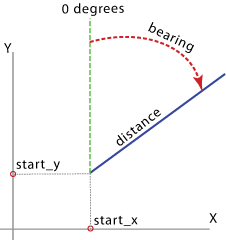

In [ ]:
def calculate_direction(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a

In [ ]:
# We will convert pandas to numpy to get the best performance
train_df['direction'] = calculate_direction(train_df['pickup_latitude'].values, train_df['pickup_longitude'].values, 
                                   train_df['dropoff_latitude'].values , train_df['dropoff_longitude'].values) 
df_test['direction'] = calculate_direction(df_test['pickup_latitude'].values, df_test['pickup_longitude'].values, 
                                   df_test['dropoff_latitude'].values , df_test['dropoff_longitude'].values) 

<h1>Normalize lat and long</h1>
* After we extract more feature from long and lat, they are less important so we will normalize them to make sure they don't impact too much to our model.
* We will convert them to radian so their range will shink from range of degrees ( 1 -> 360) to range of radians. 

In [ ]:
train_df['pickup_latitude'].apply(lambda x: np.radians(x))
train_df['pickup_longitude'].apply(lambda x: np.radians(x))
train_df['dropoff_latitude'].apply(lambda x: np.radians(x))
train_df['dropoff_longitude'].apply(lambda x: np.radians(x))

df_test['pickup_latitude'].apply(lambda x: np.radians(x))
df_test['pickup_longitude'].apply(lambda x: np.radians(x))
df_test['dropoff_latitude'].apply(lambda x: np.radians(x))
df_test['dropoff_longitude'].apply(lambda x: np.radians(x))

In [ ]:
sns.jointplot(x='distance', y='fare_amount', data=df_train)
# We can see that distance is less than 100 so it makes sense and we can use it

In [ ]:
# We extracted feature with day, week, month, year so we can remove pickup_datetime
df_train.drop(columns=['pickup_datetime'], inplace=True)

y = df_train['fare_amount']
df_train = df_train.drop(columns=['fare_amount'])

In [ ]:
df_train.head()

<h1>Modeling</h1>
* Since I don't have time and machine so I just choose lightgbm to build model
* It is fast and good for train a lot of data.
* If I have time and machine I will try with Random Forest, XGBoost, do something like grid search, random search to get the best model but for this homework I just run it 1 time



In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
x_train,x_test,y_train,y_test = train_test_split(df_train,y,random_state=123,test_size=0.1)

<h1>Params</h1>
I will choose some default value and modify it later if necessary, for example 
* if I see it overfitting, I will use smaller max_bin and num_leaves
*  if I see it is low accuracy, I will use larger max_bin and num_leaves
*  The best way is run it in a grid search with combine of paramenters but it will be slow so I will make it simple .

In [ ]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.1,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 10000 ,
        'bagging_freq': 10,
        'metric': 'rmse',  
        'zero_as_missing': True,
        'num_rounds':50000
    }

In [ ]:
train_set = lgbm.Dataset(x_train, y_train, silent=False,categorical_feature=['year','month','day','day_of_week'])
valid_set = lgbm.Dataset(x_test, y_test, silent=False,categorical_feature=['year','month','day','day_of_week'])
model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=1000,verbose_eval=500, valid_sets=valid_set)

In [ ]:
df_train.describe()

In [ ]:
test_key = df_test['key']

df_test.drop(columns=["pickup_datetime",'key'], axis=1, inplace=True)

In [ ]:
prediction = model.predict(df_test, num_iteration = model.best_iteration)      


In [ ]:
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction
})

submission.to_csv('taxi_fare_submission.csv',index=False)